# Data Cleaning and Preprocessing 

The process of data cleaning and processing is included in the source codes in cleaning_and_eda. The preprocess added the following new features: 

- Goal: given shoot was a goal. 
- Header: control or shoot balls using head. 
- Counter Attack: a counter attack. 
- Blocked: shoot was blocked. 
- Right Foot: using right foot. 
- First Half: was in first half of the match. 
- X: X coordinate of the shoot. 
- Y: Y coordinate of the shoot. 
- C: distance in Y direction from the goal. 
- strong foot: Given shoot was executed by the player's strong foot or not.  
- Distance: distance of the shoot. 
- angle_degrees: angle of the shoot converted to degrees. 


In [1]:
# Import necessary modules 
import sys  
from matplotlib import pyplot as plt
import seaborn as sns
import os
sys.path.insert(0, 'src/')

from cleaning_and_eda import * 
from visualization import * 
from Predict2 import * 

In [2]:
# All goals with added features
dataset = process_dataset("data")

# All events
event = pd.read_json("data/event/events_England.json")
for i in os.listdir("data/event"): 
    if i != "events_England.json": 
        evt = pd.read_json("data/event/" + i)
        event = pd.concat([evt, event], ignore_index = True) 

# All players
players = read_process_players("data") 

# All teams 
teams = pd.read_json("data/teams.json").rename({"wyId": "teamId"}, axis = 1) 

# EDA 

Exploratory Data Analysis to understand the basic information about datasets we use. 

**Event dataset**: all events relevent to the movement of the ball in the match. 

In [3]:
event.shape

(3251294, 12)

In [4]:
event["matchId"].nunique()

1941

In [5]:
event.isna().sum()[event.isna().sum() > 0]

Series([], dtype: int64)

There are 3251294 events happened in 1941 different matches, each event belongs to a match ideitnfied by "matchId", every event is represented by a unique "eventId". There are 12 columns in the event dataset. 


There is no missing value in the event dataset.  

**Players dataset**: all players participated in the matches. 

In [6]:
players.shape 

(3603, 13)

In [7]:
players.isna().sum()[players.isna().sum() > 0]

currentTeamId    91
dtype: int64

There are 3603 players in the dataset, each player is represented by a unique "wyId". The players dataset has 13 columns. 

There are 91 missing values in the "currentTeamId" column. It doesn't matter because we will analyze teams in the match level instead of players level.  

**Teams dataset**: add teams participated in the matches. 

In [8]:
teams.shape

(142, 6)

In [9]:
teams.isna().sum()[teams.isna().sum() > 0] 

Series([], dtype: int64)

There are 142 teams in the dataset, each team is represented by a unique "teamId". The teams dataset has 6 columns.

There is no missing value in the teams dataset.  

**Shots dataset**: all events related to shots. 

In [10]:
dataset.shape

(43075, 29)

In [11]:
dataset.isna().sum()[dataset.isna().sum() > 0] 

currentTeamId    332
dtype: int64

There are 43075 shots, each attempted goals is represented by a unique "eventId". The shots dataset has 29 columns. 

There are 332 missing values in the currentTeamId columns, but we don't need to analyze this column so it doesn't matter. 

# Data Analytics

Analyze given datasets, analyze the relationship between goals and other features, and analyze team and player performance in given events. 

In [12]:
setstyle()

Style set!


<Figure size 900x720 with 0 Axes>

<Figure size 900x720 with 0 Axes>

## Actions Analysis 

We first analyze how features in actions (distance of shots, angle of shots, etc) affect the probability of getting a goal. 

**Probability of Goal vs. Distance** 

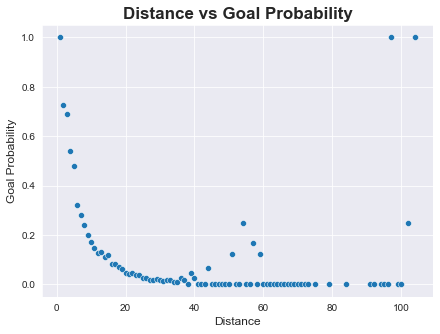

In [13]:
plt_distance_goals(dataset)

With the distance increases, the probability of getting a goal decreases. 

**Probability of Goal vs. Angle** 

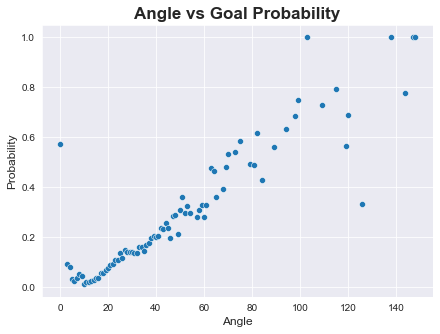

In [14]:
plt_angle_goals(dataset)

With angle increases, the probaility of getting a goal increases. 

**Probability of Goal vs. location** 

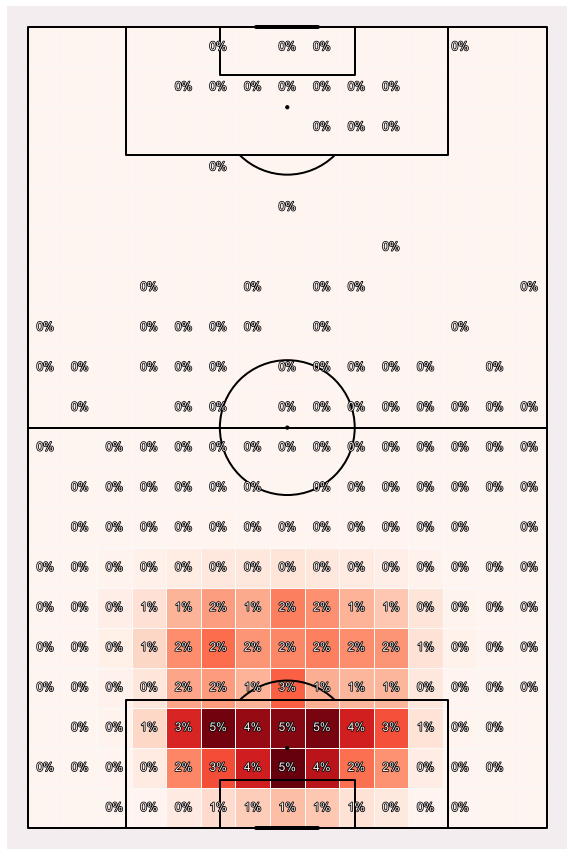

In [15]:
plt_location_goals(dataset)

The locations close to the goal and with relatively high angle have higher chance of getting a goal based on the visualization. 

**Correlation matrix with other features** 

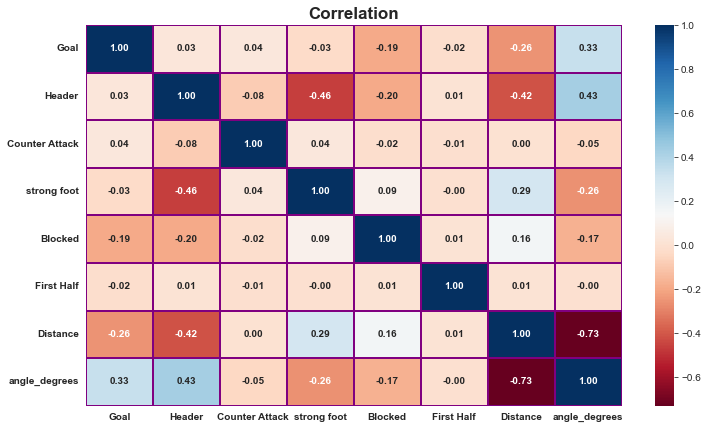

In [16]:
correlation_heatmap(dataset)

It seems the probability of getting a goal is strongly positively correlated to the Angle of shots, and it's strongly negatively correlated to the Distance of shots, which confirms our observations above. It's also negatively correlated to Blocked which makes sense because if a shot was blocked it's likely it will not get a goal. It has little correlation with other features. 

**Distribution of Distance and Angle** 

Knowing distance and angle are two most important factors affecting chance of getting goals, we want to analyze the distribution of these two features. 

In [17]:
# Distance 
print("Median: " + str(dataset["Distance"].quantile(0.5))) 
print("95% Percentile: " + str(dataset["Distance"].quantile(0.95))) 

Median: 16.812569702457743
95% Percentile: 31.86361561405108


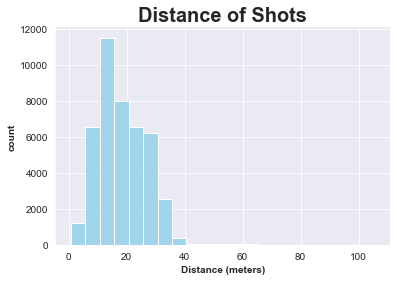

In [18]:
histp = sns.histplot(data = dataset, x = "Distance", binwidth = 5, color = "skyblue")

plt.title("Distance of Shots", weight = "bold", fontsize = 20)
plt.xlabel("Distance (meters)", weight = "semibold")
plt.ylabel("count", weight = "semibold")

sns.despine(right = True, top = True)

Over 95% shots occurred within 32 meters from the goal. Median distance is 16.8 meters. 

In [19]:
# Angle
print("Median: " + str(dataset["angle_degrees"].quantile(0.5))) 
print("95% Percentile: " + str(dataset["angle_degrees"].quantile(0.95))) 

Median: 19.275088487195234
95% Percentile: 51.81387903216682


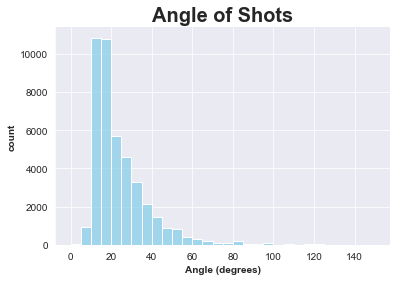

In [20]:
histp = sns.histplot(data = dataset, x = "angle_degrees", binwidth = 5, color = "skyblue")

plt.title("Angle of Shots", weight = "bold", fontsize = 20)
plt.xlabel("Angle (degrees)", weight = "semibold")
plt.ylabel("count", weight = "semibold")

sns.despine(right = True, top = True)

Over 95% shots had angle between 5 to 52 degrees. Median angle is 20 degrees. 

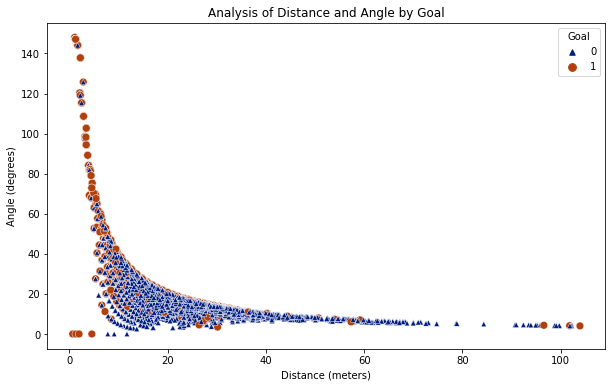

In [16]:
plt.figure(figsize=(10,6))
ax = plt.axes()
sns.scatterplot(x = 'Distance', y = 'angle_degrees', hue = 'Goal',size="Goal", sizes=(60, 30), 
                palette='dark', data = shots_model, style="Goal", markers = {0:"^", 1:"o"})
plt.xlabel("Distance (meters)")
plt.ylabel("Angle (degrees)")
ax.set_title("Analysis of Distance and Angle by Goal")
plt.show()

###### Analysis of Distance and Angle by Goal
This analysis can help user realized the relation among distance, angle and goal. We can see that as the distribution of angles and distance are similar. And as the distance increasing, the angle usually stay low. Besides, players tend to shoot in different angles when they are close to the goal.

## Teams and Players 

Other than those features of shots we analyzed above, it's also important to understant the performce of teams and players during matches. 

**Top 10 players** 

Analyze top 10 players based on the number of goals they attemped and the accuracy (the percentage of successful goals) of their attempts. Here, top 10 players are players with highest number of goals, not highest number of attempts. 

In [21]:
# Retrieve top 10 players from the shots dataset 
top50 = dataset.groupby("wyId").sum().sort_values("Goal", ascending = False)[0:50]
top50_accuracy = dataset.groupby("wyId").mean()["Goal"]

top50_attempts = dataset.groupby("wyId").count()["Goal"]
top50 = players.merge(top50, on = "wyId", how = "right")

top50["Accuracy"] = top50.apply(lambda x: top50_accuracy[x["wyId"]], axis = 1)
top50["Attempts"] = top50.apply(lambda x: top50_attempts[x["wyId"]], axis = 1)
top50 = top50.replace(to_replace = r"L. Su..*", value = "L. Suarez", regex = True)

top50[["shortName", "Attempts", "Goal", "Accuracy"]].head()

,shortName,Attempts,Goal,Accuracy
0,Mohamed Salah,141,32,0.226950
1,H. Kane,183,30,0.163934
2,Cristiano Ronaldo,196,28,0.142857
3,L. Messi,154,27,0.175325
4,E. Cavani,107,27,0.252336


Visualize the number of shots, goals and accuracy of top 10 players. The x axis represents number of goals, the y axis represents the accuracy, the size of the dot represents number of shots. 

127


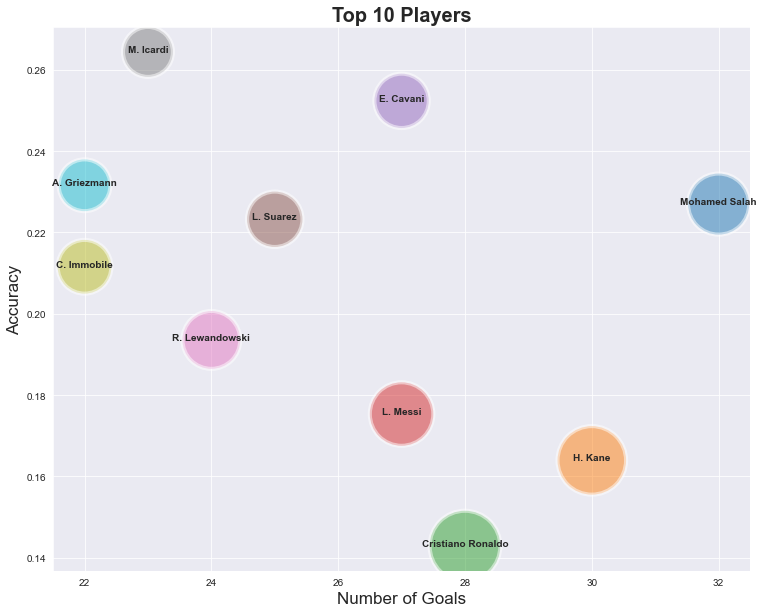

In [22]:
top10_players(top50)
print(127)

**Top 10 Teams** 

Analyze top 10 teams based on the number of goals they attemped and the accuracy (the percentage of successful goals) of their attempts. Here, top 10 teams are players with highest number of goals, not highest number of attempts.

In [23]:
# Retrieve top 10 teams from the shots dataset 
top50 = dataset.groupby("teamId").sum().sort_values("Goal", ascending = False)[0:50]
top50_accuracy = dataset.groupby("teamId").mean()["Goal"]

top50_attempts = dataset.groupby("teamId").count()["Goal"]
top50 = teams.merge(top50, on = "teamId", how = "right")

top50["Accuracy"] = top50.apply(lambda x: top50_accuracy[x["teamId"]], axis = 1)
top50["Attempts"] = top50.apply(lambda x: top50_attempts[x["teamId"]], axis = 1)
top50 = top50.replace(to_replace = r".*ayern.*", value = "Bayern Munchen", regex = True)

top50[["name", "Attempts", "Goal", "Accuracy"]].head()

,name,Attempts,Goal,Accuracy
0,Manchester City,603,94,0.155887
1,PSG,558,90,0.161290
2,Barcelona,502,87,0.173307
3,Bayern Munchen,535,83,0.155140
4,Real Madrid,631,81,0.128368


Visualize the number of attempts, goals and accuracy for top 10 teams. The x axis represents number of goals, the y axis represents the accuracy, the size of the dot represents number of attempts.

127


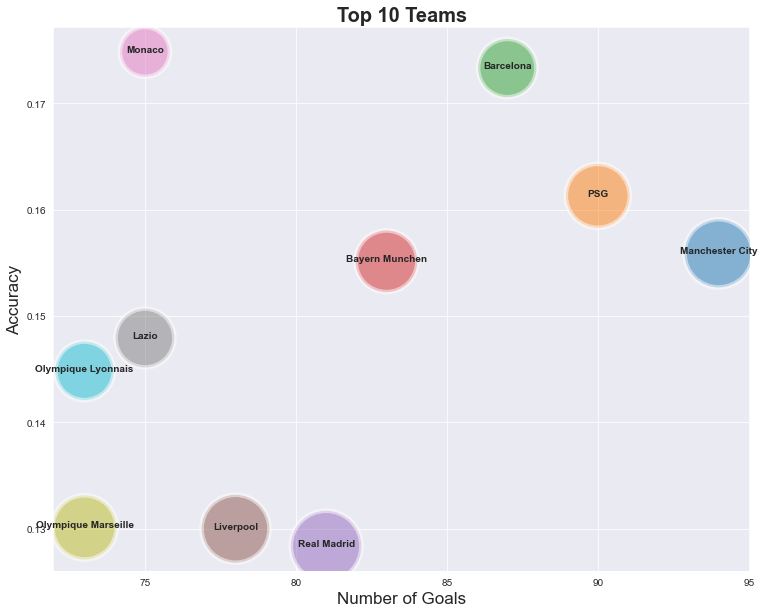

In [24]:
top10_teams(top50)
print(127)

# Model Prediction

## Training data with 9 sklearn model and visualize their classifying result to understand the relationship among distance, angle and goals, the nine models are as following

#### KNN model
we take k as 5 and predict the goal based on the nearest 5 points. If mostly points is one, then the model will guess one, otherwise it will guess zero.

#### Linear SVM
It mainly use support vectors to calculate margin and maximize it. The margin is calculate by the projection vector that obtained from two vectors. And then maximize margin under the condition that there is no point in the middle line.

#### RBF SVM
It's like Linear SVM but Project all data to higher dimensions so it can be easier to find linear hyperplanes for classifying.

#### Decision Tree
Decision Tree is learned to offer a series of questions through the features of training data, and then predict the category based on the questions. 

#### Random forest 
Random forest is derived from the decision tree but enhance its ability. It adopt several decision trees and train it with randomly picked-data. Then, take the majority decision from all decision trees as the prediction.

#### AdaBoost 
Just like random forest, AdaBoost is derived from and adopt several decision trees as classifiers to enhance its ability in classification. But adaboost trains them with several initialized weights distribution of the training data.By increasing the weight of the wrong data from the old classifier, the weighted training samples are used to train the new classifier. Therefore, the new classifier will learn more characteristics of the misclassified data.

#### Nueral Network
Use neural network with default 100 hidden layers to train a model as a non-linear classifier.

#### Gaussian Naive Bayes
This model computes the posterior probability for different distances and angles and then use this to predict the probability of goals.  

#### QDA classifier
It adopts the algorithm of linear discriminant analysis algorithm but additionally calculates the covariance of two variables (here is angle and distance) to get the relationship between the variables.


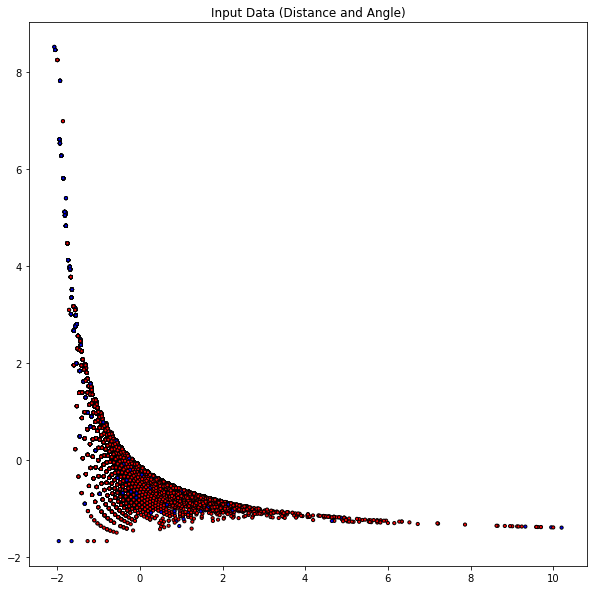

Nearest Neighbors 0.8948500418210061


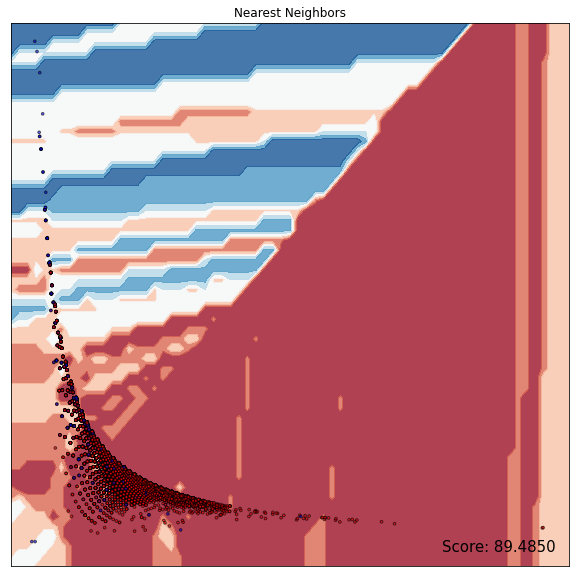

Linear SVM 0.8981957223085195


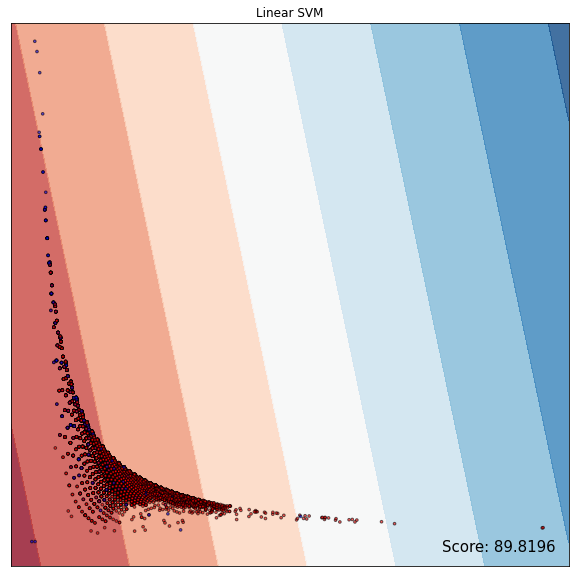

RBF SVM 0.9021388457402318


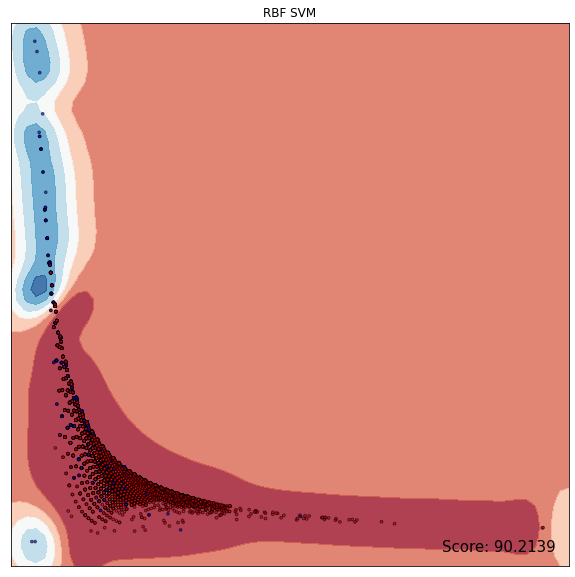

Decision Tree 0.9017803799737125


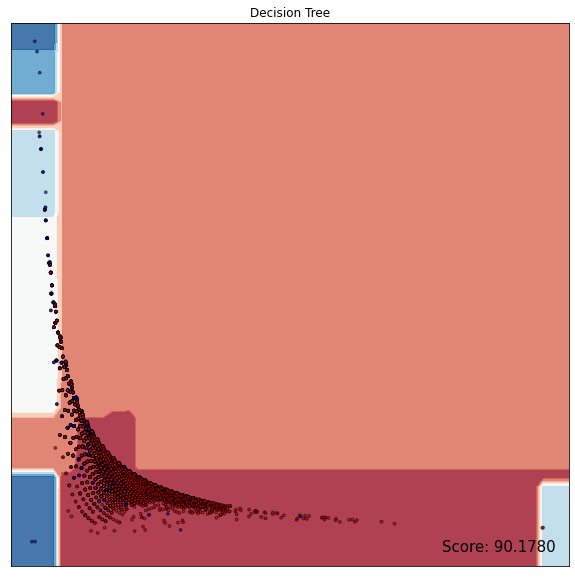

Random Forest 0.901541402796033


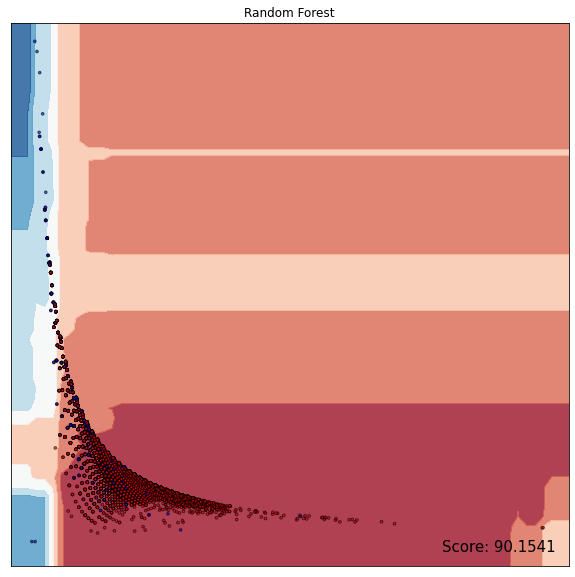

Neural Net 0.9022583343290715


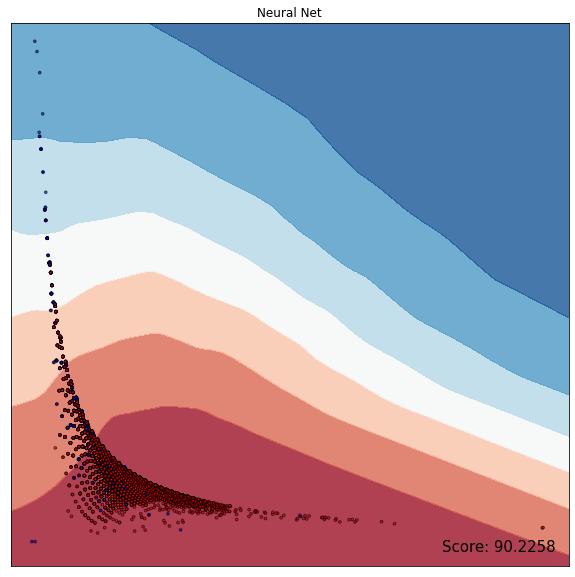

AdaBoost 0.9011829370295137


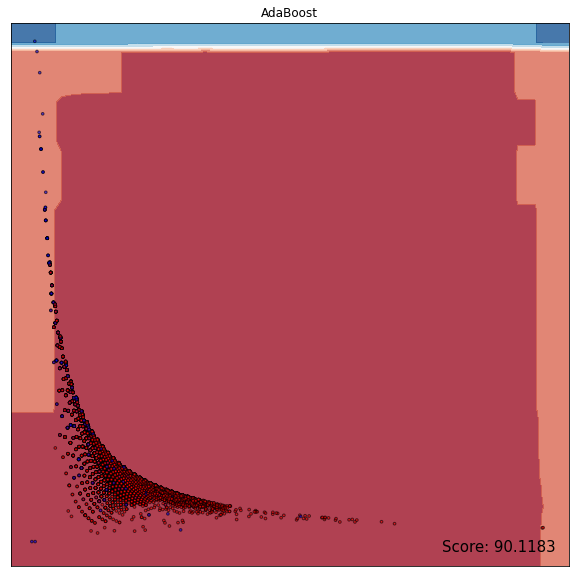

Naive Bayes 0.8848130003584658


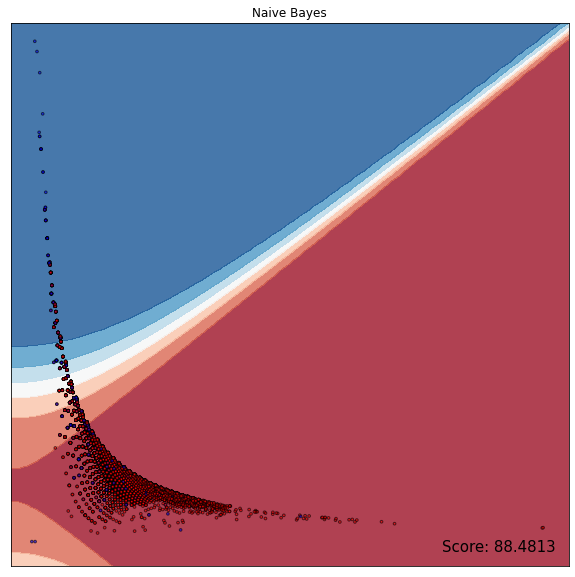

QuadraticDiscriminantAnalysis 0.8907874298004541


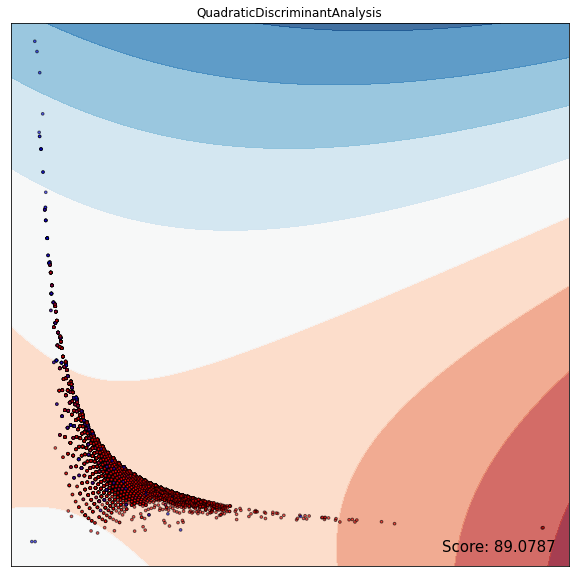

In [18]:
shots_model = dataLoader()
X, y, X_train, X_test, y_train_int, y_train, y_test_int, y_test = split_dataset(shots_model)
model_prediction_with_9models(X, y, X_train, X_test, y_train_int, y_train, y_test_int, y_test)

From Gaussian Naive Bayes, KNN, and QDA classifier for analysis, we can observe that in general the larger the distance is, the worse the shooting goal gets. And the figures also show that the effect of different angles plays a minor role when the player gets closer.

From another three tree-like models, decision tree, random forest, and AdaBoost, we can easily observe that models still tend to predict positively in several angles, not just small ones. So the skewness didn’t change anything to the correlation.

Besides, Multi-layers perceptron model and SVM models. All can solve non-linear problems and reach a really high scores but take time to train. 

##### Overall, our models prove that our assumption that distance and angles play a main role is correct since all of our models reach high scores.
##### And second, the skewness of the angle didn’t affect the positive correlation to the goal while not for the distance. 
##### Lastly, we can also conclude that the distance is more important than the angle do.
